In [1]:
%load_ext autoreload

## Dependencies

* datetime, numpy, matplotlib, seaborn, pandas, 
* utilhysplit available at https://github.com/noaa-oar-arl/utilhysplit
* monetio available at https://github.com/noaa-oar-arl/monetio

## CONTENTS

#### data directory
* netcdf files containing HYSPLIT output
* volcat directory
    * regridded and parallax corrected VOLCAT data
    * GEFS directory
        * GEFS meteorology in ARL format
    * gfs0p25 directory
        * GFS meteorology in ARL format

#### notebooks directory
* jupyter notebooks
    * Notebooks for running inversion algorithm
        * BezyInverseRunM.ipynb
        * BezyInverseRunB.ipynb
        * BezyInverseRunC.ipynb
        * BezyInverseRunD.ipynb
        * BezyInverseRunE.ipynb
        * BezyInverseRunPartSize.ipynb

* python scripts
    * cases.py functions for creating plots
        
* graphics directory
    * graphics files created from notebooks
    * FigureScripts directory
        * scripts for creating multi-panel figures with ImageMagick






In [6]:
%autoreload
import utilhysplit

UsageError: Line magic function `%autoreload` not found.


In [3]:
from utilvolc import volcat_logic

In [4]:
import geopandas

In [5]:
from utilhysplit import parutils

In [6]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from monetio.models import hysplit

In [7]:
from utilvolc import volcat
import utilvolc.ash_inverse as ai
import utilvolc.ash_eval as ae
from utilvolc import volcMER
from utilhysplit.evaluation import ensemble_tools
from utilhysplit.evaluation import plume_stat
import cases

## SETUP
* RunM 
* Emissions determined from inversion algorithm with all 31 members of the GEFS. 
* Emissions determined using all observations up to 10/22 00:00 UTC.
  * time2 21-22 UTC
  * time3 22-23 UTC
  * time4 23-00 UTC
* Clear sky observations within 3 pixels from non-clear sky observations were not utilized in inversion.

In [8]:
%autoreload
case = cases.runM(subset='M_2_3_4_TFw7')
print(case)
tag = case.vhash['tag']
tdir = case.vhash['tdir']
tname = case.vhash['tname']
configdir= case.vhash['configdir']
configfile = case.vhash['configfile']
vdir = case.vhash['vdir']
vid = case.vhash['vid']
gdir = case.vhash['gdir']
graphicstype = case.vhash['graphicstype']
vloc = case.vhash['vloc']
tname = 'RunM4.nc'

vloc : [160.587, 55.978]
tag : M
tdir : ../RunM/RunM_2_3_4_TFw7
tname : RunM.nc
configdir : ../RunM
configfile : config.invbezyM.txt
vdir : ../data/volcat/
vid : v300250
gdir : ./graphics/
graphicstype : png



In [9]:
try:
    aeval.close_arrays()
except:
    pass

In [10]:
# create instance of the AshEval class.
%autoreload
aeval = ae.AshEval(tdir,tname,vdir,vid,configdir=configdir,configfile=configfile)
print('done')

done


In [11]:
%autoreload
#time list to prepare.
# start with one hour after eruption. 21:00-22:00
dlist = []
sdate = datetime.datetime(2020,10,21,22,0)
#sdate = datetime.datetime(2020,10,22,12,0)
dt = datetime.timedelta(hours=1)
for iii in np.arange(1,16):
    drange = [sdate, sdate+dt]
    dlist.append(drange)
    sdate += dt
print(dlist[0])
print(dlist[-1])

[datetime.datetime(2020, 10, 21, 22, 0), datetime.datetime(2020, 10, 21, 23, 0)]
[datetime.datetime(2020, 10, 22, 12, 0), datetime.datetime(2020, 10, 22, 13, 0)]


In [12]:
# time averages observations
# matches observations and model forecast to the same domain.
# these are stored in dictionaries.
%autoreload
d1 = datetime.datetime(2020,10,22,1)
d2 = datetime.datetime(2020,10,22,2)
for drange in dlist:
    print(drange)
    aeval.prepare_one_time(drange)

[datetime.datetime(2020, 10, 21, 22, 0), datetime.datetime(2020, 10, 21, 23, 0)]
[datetime.datetime(2020, 10, 21, 23, 0), datetime.datetime(2020, 10, 22, 0, 0)]
[datetime.datetime(2020, 10, 22, 0, 0), datetime.datetime(2020, 10, 22, 1, 0)]
[datetime.datetime(2020, 10, 22, 1, 0), datetime.datetime(2020, 10, 22, 2, 0)]
[datetime.datetime(2020, 10, 22, 2, 0), datetime.datetime(2020, 10, 22, 3, 0)]
[datetime.datetime(2020, 10, 22, 3, 0), datetime.datetime(2020, 10, 22, 4, 0)]
[datetime.datetime(2020, 10, 22, 4, 0), datetime.datetime(2020, 10, 22, 5, 0)]
[datetime.datetime(2020, 10, 22, 5, 0), datetime.datetime(2020, 10, 22, 6, 0)]
[datetime.datetime(2020, 10, 22, 6, 0), datetime.datetime(2020, 10, 22, 7, 0)]
[datetime.datetime(2020, 10, 22, 7, 0), datetime.datetime(2020, 10, 22, 8, 0)]
[datetime.datetime(2020, 10, 22, 8, 0), datetime.datetime(2020, 10, 22, 9, 0)]
[datetime.datetime(2020, 10, 22, 9, 0), datetime.datetime(2020, 10, 22, 10, 0)]
[datetime.datetime(2020, 10, 22, 10, 0), datetim

In [13]:
# time periods available.
aeval.volcat_avg_hash.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

## CDF matching for bias correction

In [14]:
# df2 can be used for bias correction
%autoreload
enslist = np.arange(0,31,1)
#enslist=['gep09']
df2 = ae.cdf_match(aeval,[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],enslist,thresh=0.1)
#df2 = ae.cdf_match(aeval,[2],enslist,thresh=0.1)


chop the forecast 20 0.1 <xarray.DataArray (dim_0: 1)>
array([0.])
Dimensions without coordinates: dim_0
chop the forecast 20 0.1 <xarray.DataArray (dim_0: 1)>
array([0.])
Dimensions without coordinates: dim_0


In [15]:
# creates dataframe where all negative intercepts changed to positive.
# this can be used when don't want to add values.
def get(x):
    if x['intercept'] < 0: 
        return 0
    else: 
        return x['intercept']

df3 = df2.copy()
df3[df3['intercept']<0]
df3['intercept'] = df3.apply(lambda row: get(row),axis=1 )


/hysplit-users/alicec/utilhysplit/utilvolc/ash_eval.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.ax = self.fig.add_subplot(1,1,1)


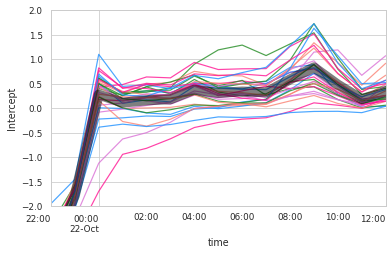

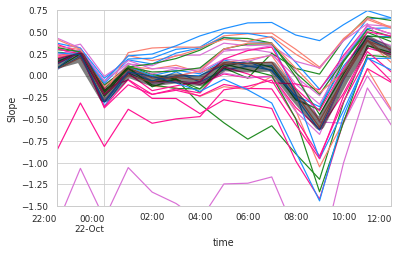

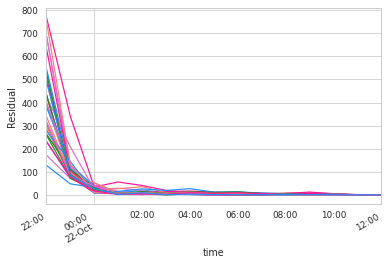

In [16]:
%autoreload
dplot = ae.matchplots(df2)
dplot.set_axis(1)
dplot.plot_intercept()
ax = plt.gca()
ax.set_ylim(-2,2)
plt.savefig('cdfmatch_intercept_{}.png'.format(tag))
dplot.set_axis(2)
dplot.plot_slope()
ax = plt.gca()
ax.set_ylim(-1.5,0.75)
plt.savefig('cdfmatch_slope_{}.png'.format(tag))
dplot.set_axis(3)
dplot.plot_residual()
#turquoise is gep09 
#organe is gep11

In [17]:
temp = df2[df2['time']==datetime.datetime(2020,10,22,0)]
temp[temp['intercept']<0]

,slope,slope2,intercept,time,ens,pmthresh,residual
122,-0.814987,-1.699259,-1.699259,2020-10-22,gep09,0.019558,34.618369
152,-1.642951,-1.123995,-1.123995,2020-10-22,gep11,0.070674,23.775627
287,-0.089597,-0.222237,-0.222237,2020-10-22,gep20,0.416965,36.273020
302,-0.008043,-0.081642,-0.081642,2020-10-22,gep21,0.662557,19.675781
362,-0.066084,-0.388523,-0.388523,2020-10-22,gep25,0.495411,6.467181


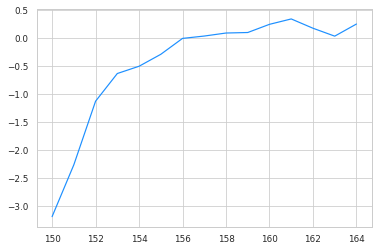

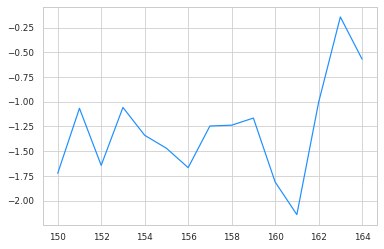

In [18]:
dplot.plot_one('gep11')

In [19]:
mer=0.0066
print(mer*2.25)

0.01485


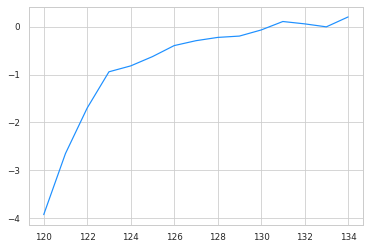

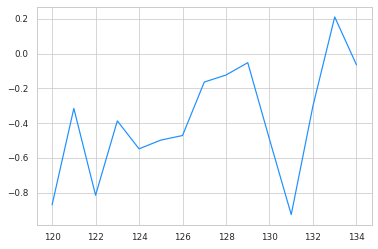

In [20]:
%autoreload
dplot.plot_one('gep09')

#### Compare mass loading plots of corrected and un-corrected simulation

<ipython-input-22-7f8d5403355f>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tem = tem[dfcdf['time']==time]


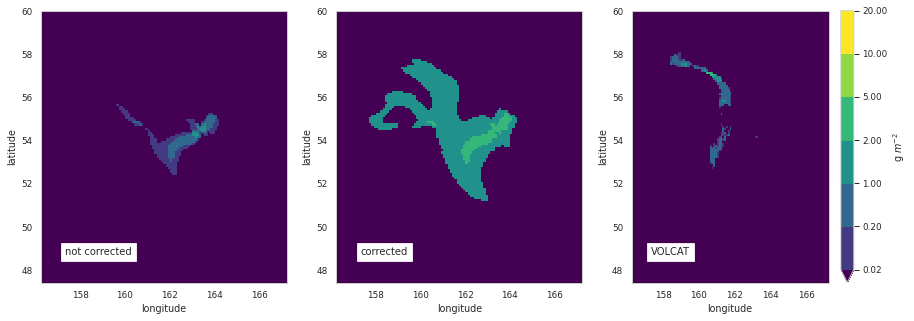

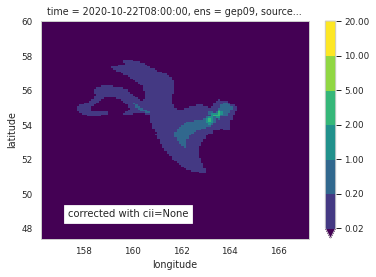

In [22]:

def mplot1(tii,ens):
    fig = plt.figure(1,figsize=(15,5))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    
    fig2 = plt.figure(2)
    ax = fig2.add_subplot(1,1,1)
    
    dfcdf = df2.copy()
    #ens='gec00'
    #tii=14
    levels = [0.02,0.2,1,2,5,10,20]
    #print(aeval.cdump.ens.values[ens])
    time = aeval.get_time(tii)
    tem = dfcdf[dfcdf['ens']==ens]
    tem = tem[dfcdf['time']==time]
    tem
    cii = datetime.datetime(2020,10,22,0)
    aeval.set_bias_correction(slope=None, intercept=None, dfcdf=pd.DataFrame())
    volcat,forecast = aeval.get_pair(tii,cii=cii)
    f1=forecast.sel(ens=ens)

    # bias correction with cii=None
    aeval.set_bias_correction(slope=None, intercept=None, dfcdf=df2)
    volcat,forecast = aeval.get_pair(tii,cii=None)
    f3=forecast.sel(ens=ens)
    f3.plot.pcolormesh(ax=ax, x='longitude',y='latitude',levels=levels)
    
    
    aeval.set_bias_correction(slope=None, intercept=None, dfcdf=df2)
    volcat,forecast = aeval.get_pair(tii,cii=cii)
    f2=forecast.sel(ens=ens)

    
    #plt.show()
    
    # bias corrected with df2 and cii=00z
    f2.plot.pcolormesh(ax = ax2, x='longitude',y='latitude',levels=levels,add_colorbar=False)

    
    # no bias correction
    f1.plot.pcolormesh(ax=ax1, x='longitude',y='latitude',levels=levels,add_colorbar=False)

    
    volcat = volcat.fillna(0)
    volcat.plot.pcolormesh(ax=ax3,x='longitude',y='latitude',levels=levels,cbar_kwargs={'label':'g $m^{-2}$'})

    ax1.text(0.1,0.1, 'not corrected', transform=ax1.transAxes,size=10,bbox=dict(facecolor='white'))
    ax2.text(0.1,0.1, 'corrected', transform=ax2.transAxes,size=10,bbox=dict(facecolor='white'))
    ax3.text(0.1,0.1, 'VOLCAT', transform=ax3.transAxes,size=10,bbox=dict(facecolor='white'))
    
    ax.text(0.1,0.1, 'corrected with cii=None', transform=ax.transAxes,size=10,bbox=dict(facecolor='white'))
    
    ax1.set_title('')
    ax2.set_title('')
    ax3.set_title('')
    return fig
   
tii=12
ens='gep09'
fig = mplot1(tii,ens)
fig.savefig(gdir + 'cdfmatch_pmesh{}_t{}_ens{}.png'.format(tag,tii,ens))    
tii=10

###### 

2020-10-22 06:00:00
gep09


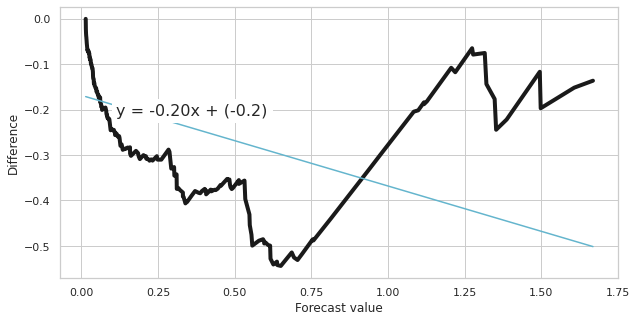

          name      mean  variance  skewness  kurtosis    N       min  \
0          obs  0.462356  0.173705  1.056352  0.211630  331  0.014386   
1           fc  0.244687  0.109859  2.065339  4.186391  331  0.013685   
2    corrected  0.462356  0.158018  2.065339  4.186391  331  0.185310   
3  corrected 0  0.462356  0.158018  2.065339  4.186391  331  0.185310   

        max  
0  1.804511  
1  1.667863  
2  2.169207  
3  2.169207  


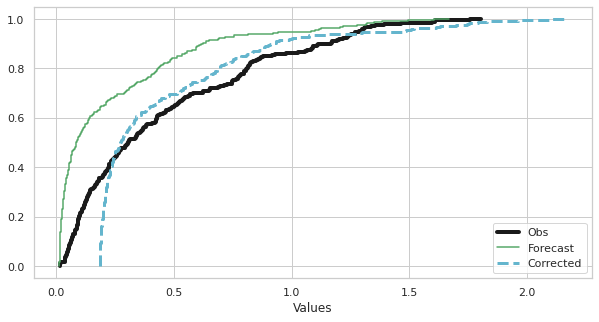

[-0.19932506 -0.16889715]
<xarray.DataArray (dim_0: 1)>
array([0.01368536])
Dimensions without coordinates: dim_0
2020-10-22 00:00:00
gep09


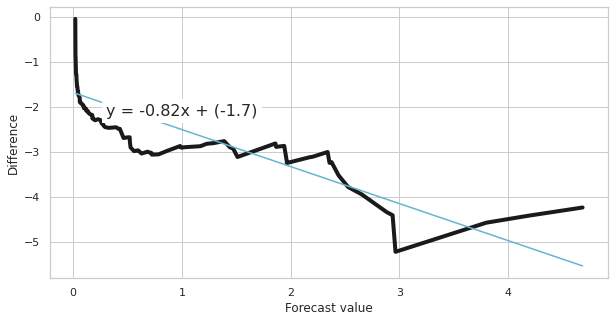

          name      mean  variance  skewness  kurtosis    N       min  \
0          obs  2.682639  2.938015  1.515452  2.308458  154  0.065149   
1           fc  0.547783  0.811350  2.250559  4.995097  154  0.019384   
2    corrected  2.682639  2.693698  2.250559  4.995097  154  1.719846   
3  corrected 0  2.682639  2.693698  2.250559  4.995097  154  1.719846   

         max  
0   8.926088  
1   4.687267  
2  10.225161  
3  10.225161  


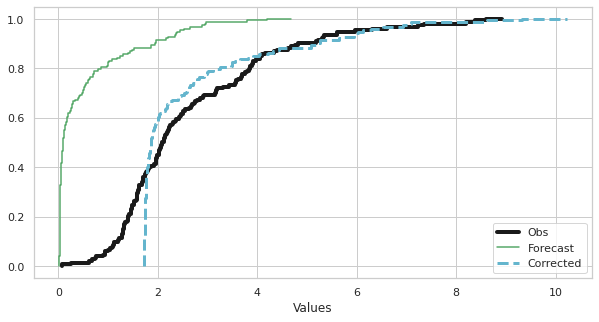

[-0.82209255 -1.68452747]
<xarray.DataArray (dim_0: 1)>
array([0.01938373])
Dimensions without coordinates: dim_0


In [23]:
from utilhysplit.evaluation import cdf_matching

# This will show the CDF matching using the values computed at that time.

def cplot(tii,ens):
    %autoreload
    sns.set()
    sns.set_style('whitegrid')

    print(aeval.get_time(tii))
    #ens=7
    print(aeval.cdump.sel(ens=ens).ens.values)
    makeplots=True

    #aeval.set_concmult(1)
    biastag = ''
    aeval.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame())
    #aeval.set_bias_correction()
    volcat,forecast = aeval.get_pair(tii)
    pmthresh, poly, fc, fc2 = cdf_matching.cdf_match_volcat(forecast,volcat,thresh=0.01,ens=ens,scale=1,pfit=1,makeplots=makeplots,
                                             figname=gdir + 'cdfmatch{}_ens{}_time{}'.format(tag,ens,tii),
                                             figsize=(10,5))
    #ax = plt.gca()


    #ax.set_xscale('log')

    print(poly)
    print(pmthresh)

cplot(tii,ens)
cplot(4,ens)


## Compare CDF's with bias correction

gep12


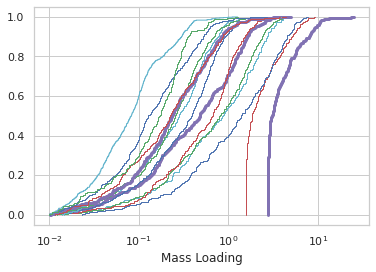

In [24]:
%autoreload
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
for ens in aeval.cdump.ens.values[11:12]:
    print(ens)
    cii = None
    #cii=None
    aeval.model_cdf_plot(ens=ens,threshold=0.01,cii=cii)
    plt.show()

gep12


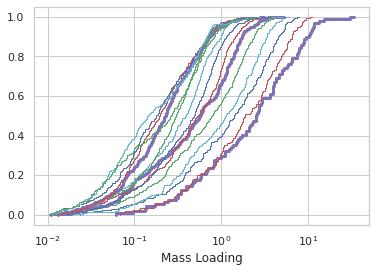

In [25]:
%autoreload
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
for ens in aeval.cdump.ens.values[11:12]:
    print(ens)
    cii = datetime.datetime(2020,10,22,0)
    #cii=None
    aeval.model_cdf_plot(ens=ens,threshold=0.01,cii=cii)
    plt.show()

gep12


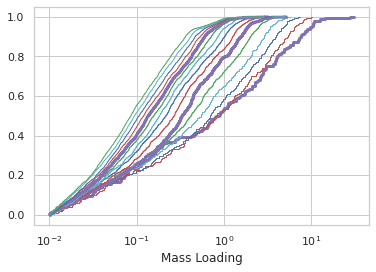

In [26]:
%autoreload
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame())
for ens in aeval.cdump.ens.values[11:12]:
    print(ens)
    aeval.model_cdf_plot(ens=ens,threshold=0.01)
    plt.show()

# Fractions Skill Score FSS, MAE, and MSE

### MAE, MSE, POD, RMSE, FAR, CSI, Bias

In [27]:
%autoreload



def make_dfmse(aeval, threshold,cii):
    pixel_match=False
    volcat=[]
    forecast=[]
    for tii in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
        #print(tii)
        obs, model = aeval.get_pair(tii,cii=cii)
        forecast.append(model)
        volcat.append(obs)

    # dft is a pandas dataframe with FSS information
    # dft2 is pandas dataframe with MSE, MAE information.
    dfss, dfmse = ensemble_tools.ens_time_fss(forecast,volcat,threshold=threshold,
                                      neighborhoods=[1,3,5,7,9,11,13,15,17,19,21],plot=False,
                                      pixel_match=pixel_match)
    return dfss, dfmse




In [28]:
%autoreload
threshold=0.2
threshstr = str(threshold).replace('.','p')
aeval.set_bias_correction(intercept=None,slope=None,dfcdf=df2)
cii = datetime.datetime(2020,10,22,0)
cii=None
dfss, dfmse = make_dfmse(aeval,threshold,cii)

In [32]:
%autoreload
def dfmseplots(dfmse):
    pmtag=''
    sns.set()
    biastag=''
    sns.set()
    sns.set_style('whitegrid')
    ensemble_tools.plot_ens_accuracy(dfmse,'MAE')
    plt.savefig(gdir + 'run{}_mae_ts_t{}{}.{}'.format(tag,threshold,pmtag,graphicstype))
    plt.show()
    ensemble_tools.plot_ens_accuracy(dfmse,'MSE')
    plt.savefig(gdir + 'run{}_mse_ts_t{}{}.{}'.format(tag,threshold,pmtag,graphicstype))
    plt.show()
    ensemble_tools.plot_ens_accuracy(dfmse,'RMSE')
    ax = plt.gca()
    ax.set_yscale('log')
    plt.savefig(gdir + 'run{}_rmse_ts_t{}{}.{}'.format(tag,threshold,pmtag,graphicstype))
    ensemble_tools.plot_ens_accuracy(dfmse,'fractional_bias')
    plt.savefig(gdir + 'run{}_FB_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
    plt.show()
    ensemble_tools.plot_ens_accuracy(dfmse,'bias')
    plt.savefig(gdir + 'run{}_bias_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
    plt.show()
    ensemble_tools.plot_ens_accuracy(dfmse,'CSI')
    plt.savefig(gdir + 'run{}_CSI_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
    plt.show()
    ensemble_tools.plot_ens_accuracy(dfmse,'POD')
    plt.savefig(gdir + 'run{}_POD_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
    plt.show()
    ensemble_tools.plot_ens_accuracy(dfmse,'FAR')
    plt.savefig(gdir + 'run{}_FAR_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))

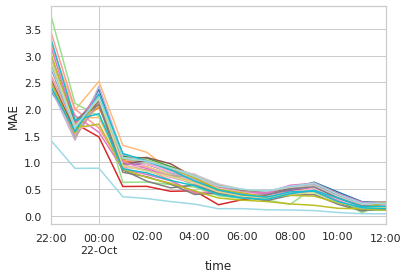

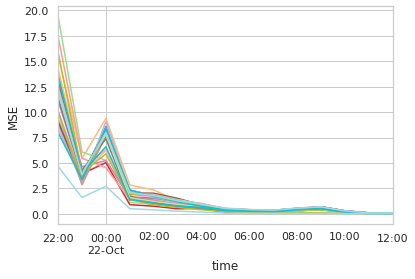

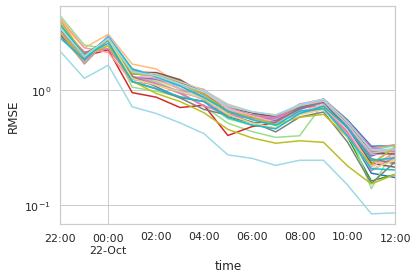

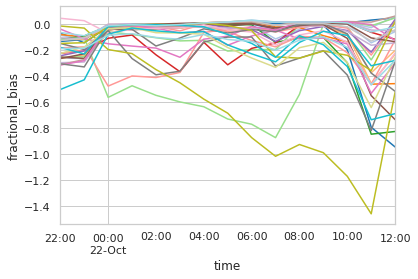

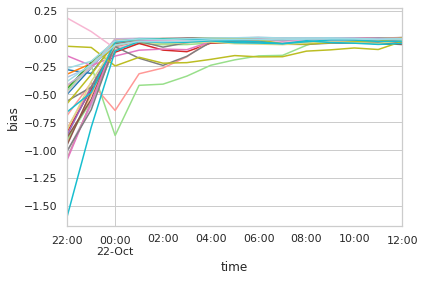

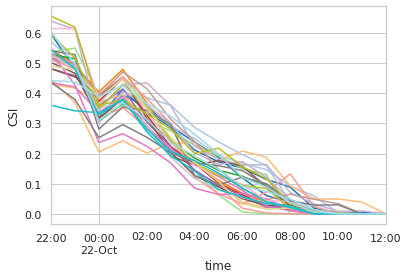

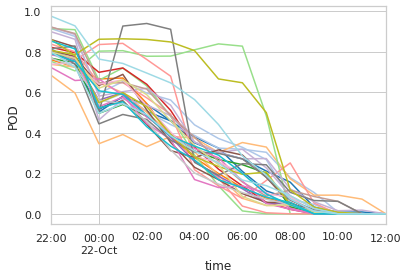

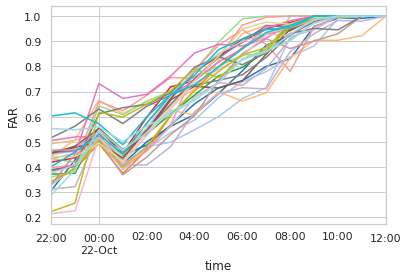

In [33]:
dfmseplots(dfmse)

In [ ]:
# NOT bias corrected.
%autoreload
threshold=0.2
threshstr = str(threshold).replace('.','p')
aeval.set_bias_correction(intercept=None,slope=None,dfcdf=pd.DataFrame())
cii = datetime.datetime(2020,10,22,0)
dfssb, dfmseb = make_dfmse(aeval,threshold,cii)

In [ ]:
dfmseplots(dfmseb)

### SETUP Eval Object

In [36]:
%autoreload
bctag = 'None'
eobj_nc = cases.EvalObj('M',aeval)
eobj_nc.set_bias_correction(None,None,dfcdf=pd.DataFrame())
enslist = eobj_nc.maketaglistall()


### Plots of Area

0 2 0.2
1 2 2


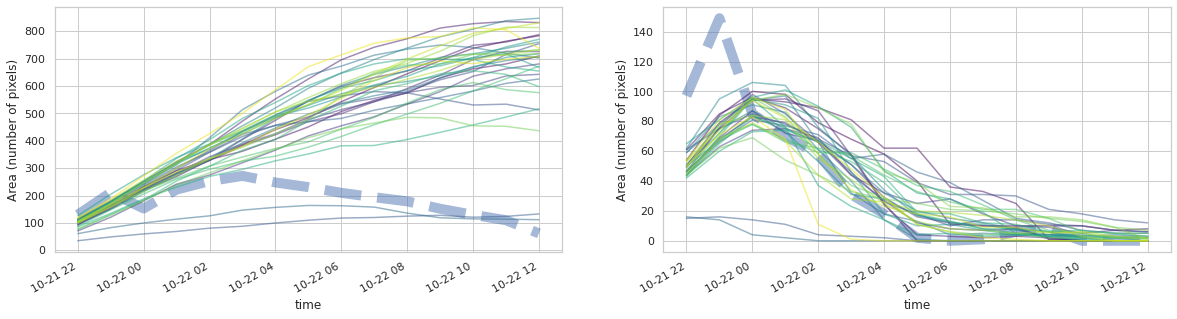

In [37]:
eobj_nc.plot_areaA(enslist, legend=False)
plt.savefig('Area{}_bc{}.png'.format(tag,bctag))

0 2 0.2
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' '

1 2 2
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'ge

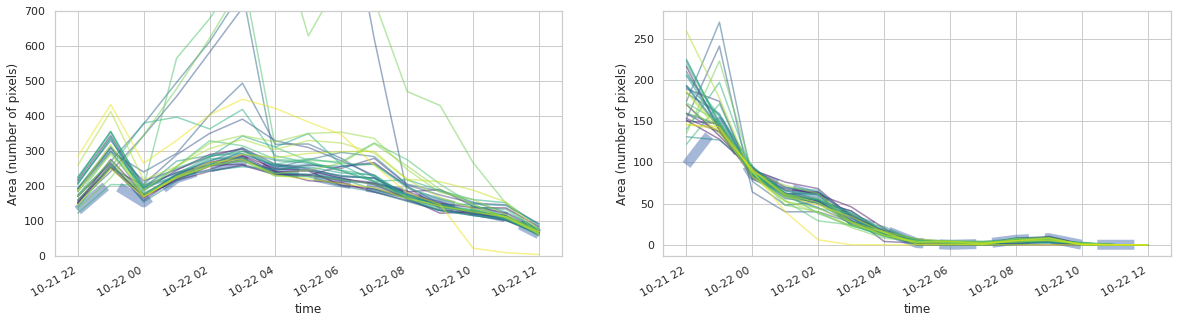

In [38]:
# bias correction added
%autoreload
bctag='df2'
eobj_bc = cases.EvalObj('M',aeval)
enslist = eobj_bc.maketaglistall()
#cii = datetime.datetime(2020,10,22,0)
cii=None
eobj_bc.set_bias_correction(slope=None,intercept=None, dfcdf=df2,cii = cii)
#eobj_bc.plot_areaA(enslist[0:10], legend=False)
#ax = plt.gca()
axlist = eobj_bc.plot_areaA(enslist[0:10], legend=False)
axlist[0].set_ylim(0,700)
plt.savefig('Area{}_bc{}.png'.format(tag,bctag))
plt.show()
#ax.set_ylim(0,500)
#plt.savefig('Area{}_taglistA.png'.format(tag))

0 2 0.2
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' '

1 2 2
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'ge

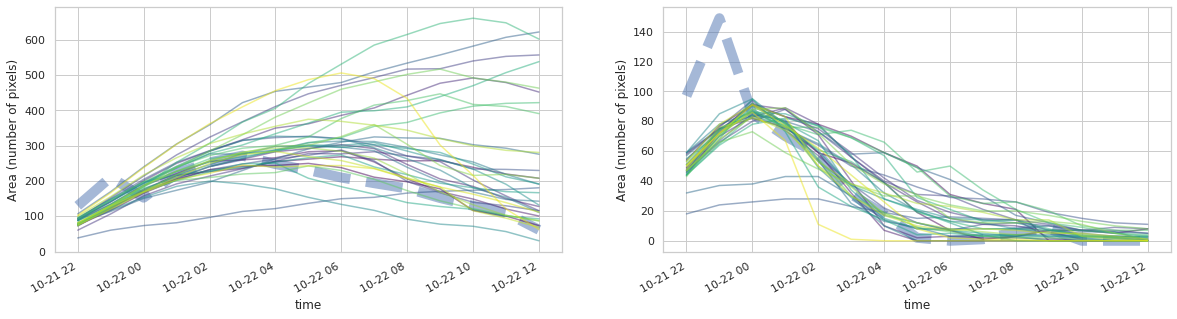

In [39]:
%autoreload
# use 22 at 00UTC. No negative intercepts allowed.
bctag='cii00_df3'
cii=datetime.datetime(2020,10,22,0)
eobj_bc.set_bias_correction(slope=None,intercept=None, dfcdf=df3,cii = cii)
axlist = eobj_bc.plot_areaA(enslist, legend=False)
plt.savefig('Area{}_bc{}.png'.format(tag,bctag))
#for ax in axlist:
#axlist[0].set_ylim(0,500)
#axlist[1].set_ylime(0,200)
#ax = plt.gca()

0 2 0.2
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' '

1 2 2
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'ge

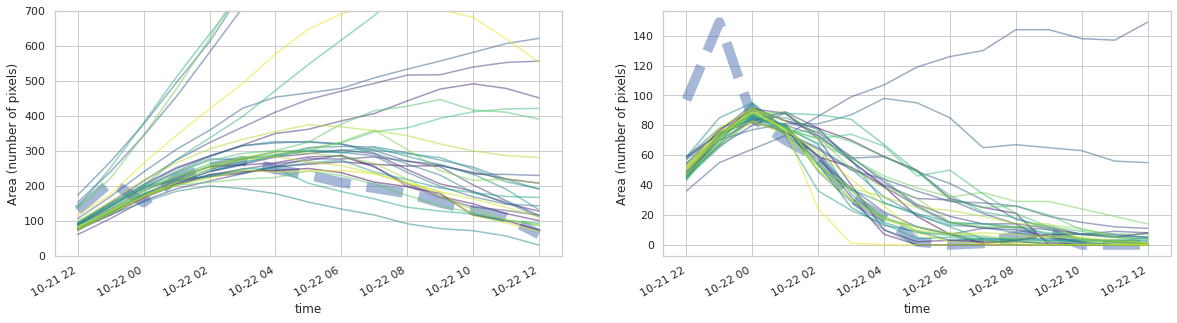

In [40]:
# use 22 at 00UTC. Allow negative intercepts
cii=datetime.datetime(2020,10,22,0)
bctag='cii00_df2'

eobj_bc.set_bias_correction(slope=None,intercept=None, dfcdf=df2,cii = cii)
axlist = eobj_bc.plot_areaA(enslist[0:10], legend=False)
axlist[0].set_ylim(0,700)
plt.savefig(gdir + 'Area{}_bc{}.png'.format(tag,bctag))
plt.show()

['gep09', 'gep10', 'gep11', 'gep12', 'gep13']
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'ge

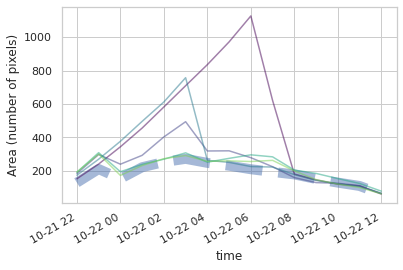

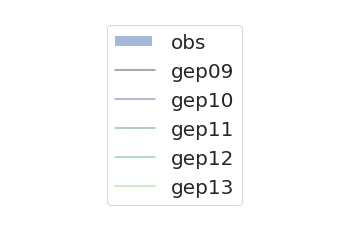

['gep19', 'gep20', 'gep21', 'gep22', 'gep23']
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'ge

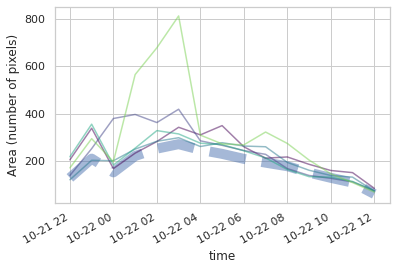

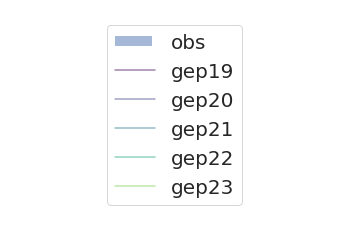

['gep24', 'gep25', 'gep26', 'gep27', 'gep28']
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'ge

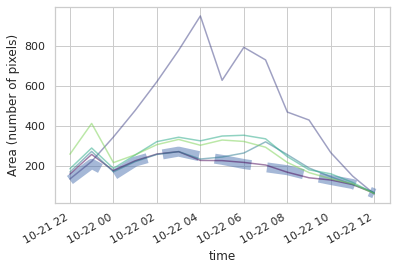

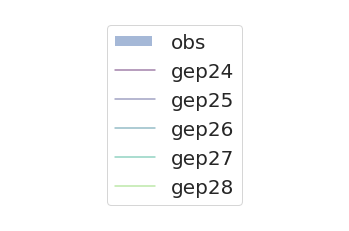

['gep29', 'gep30', 'gep01', 'gep02', 'gec00']
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'ge

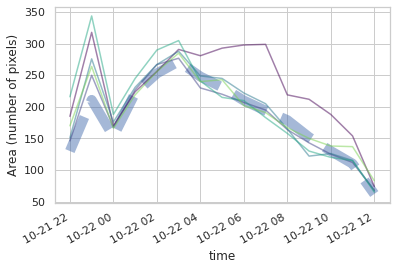

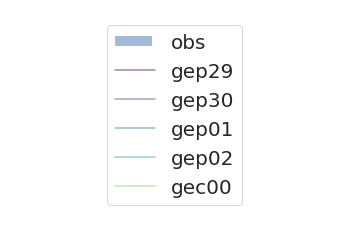

['gep03', 'gep04', 'gep05', 'gep06', 'gep07', 'gep08']
cdump A ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
xrt ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
f2 ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'gep21' 'gep22' 'gep23' 'gep24' 'gep25' 'gep26' 'gep27'
 'gep28' 'gep29' 'gep30' 'gec00']
cdump ['gep01' 'gep02' 'gep03' 'gep04' 'gep05' 'gep06' 'gep07' 'gep08' 'gep09'
 'gep10' 'gep11' 'gep12' 'gep13' 'gep14' 'gep15' 'gep16' 'gep17' 'gep18'
 'gep19' 'gep20' 'g

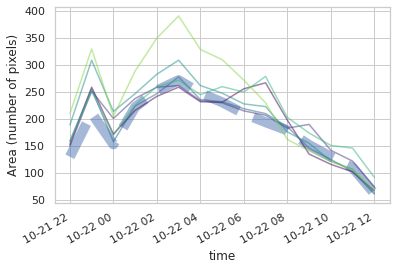

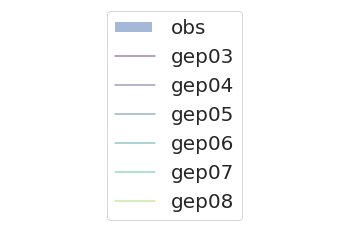

In [41]:
%autoreload
#tlg2.enslist = tlg2.maketaglistall()
cii = None
enslist=[]
eobj_bc.set_bias_correction(slope=None,intercept=None, dfcdf=df2,cii = cii)
e1=['gep09','gep10','gep11','gep12','gep13']
e2=['gep19','gep20','gep21','gep22','gep23']
e3=['gep24','gep25','gep26','gep27','gep28']
e4=['gep29','gep30','gep01','gep02','gec00']
e5=['gep03','gep04','gep05','gep06','gep07','gep08']
elist = [e1,e2,e3,e4,e5]
for ens in elist:
     print(ens)
     eobj_bc.set_thresholds(coarsen=0,threshold=0.2,enslist=ens)
     eobj_bc.plot_area(legend=True)
     plt.show()
%autoreload
#tlg2.enslist = tlg2.maketaglistall()

#ax = plt.gca()
#ax.set_ylim(0,200)

NameError: name 'model' is not defined

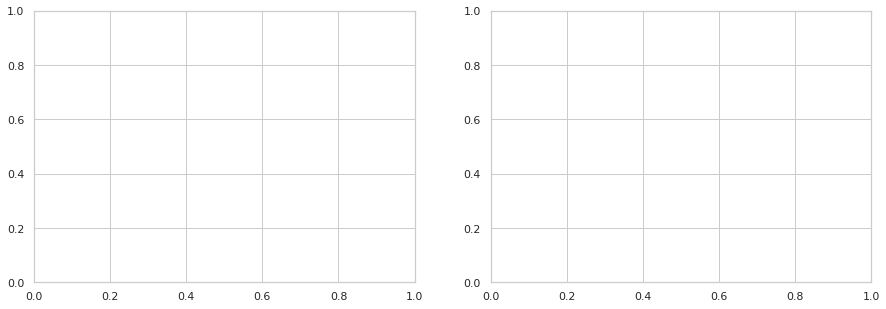

In [42]:
for ens in np.arange(5,10):
    fig = plt.figure(1,figsize=(15,5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    print(model.isel(ens=ens).ens.values)
    levels = [0.002,0.2,2,5,10]    
    obs.plot.pcolormesh(ax = ax1, levels = levels)
    model.isel(ens=ens).plot.pcolormesh(ax=ax2, levels = levels)
    plt.show()
    


### FSS vs time

In [ ]:
enslist = eobj_bc.maketaglistall()

In [ ]:
# no bias correction
%autoreload
cii=None
eobj_nc.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame(),cii=cii)
eobj_nc.set_thresholds(coarsen=0,threshold=0.2,enslist=enslist)
#print(tlg.threshstr)
eobj_nc.plot_fssA(neighborhood=5)
eobj_nc.plot_afss()
ax = plt.gca()
ax.set_ylim(0,1.01)
fig = plt.gcf()
fig.savefig('AFSSM_none.png')

In [ ]:
%autoreload
cii=None
eobj_bc.set_bias_correction(slope=None,intercept=None,dfcdf=df2,cii=cii)
eobj_bc.set_thresholds(coarsen=0,threshold=0.2,enslist=enslist)
print(eobj_bc.threshstr)
eobj_bc.plot_fssA(neighborhood=5)
eobj_bc.plot_afss()

In [ ]:
%autoreload
cii=datetime.datetime(2020,10,22,0)
eobj_bc.set_bias_correction(slope=None,intercept=None,dfcdf=df3,cii=cii)
eobj_bc.set_thresholds(coarsen=0,threshold=0.2,enslist=enslist)
print(eobj_bc.threshstr)
eobj_bc.plot_fssA(neighborhood=11)
eobj_bc.plot_afss()
ax = plt.gca()
ax.set_ylim(0,1.01)
fig = plt.gcf()
fig.savefig('AFSSM_df3.png')

In [ ]:
%autoreload
nnn=11
cii=datetime.datetime(2020,10,22,0)
eobj_bc.set_bias_correction(slope=None,intercept=None,dfcdf=df2,cii=cii)
eobj_bc.set_thresholds(coarsen=0,threshold=0.2,enslist=enslist)
print(eobj_bc.threshstr)
eobj_bc.plot_fssA(neighborhood=nnn)
ax = plt.gca()
ax.set_ylim(0,1.01)
eobj_bc.plot_afss()
ax = plt.gca()
ax.set_ylim(0,1.01)
fig = plt.gcf()
fig.savefig('AFSSM_df2.png')

### FSS as a function of neighborhood size for one time period.
#### plot_fssC
* (a) no bias correction
* (b) bias correction with intercept at 00 UTC
* (c) bias correction with intercept at 00 UTC but no negative intercepts
* (d) bias correction using current time

In [ ]:
%autoreload
tii=13
eobj_bc.plot_fssC(tii,df2,df3)
plt.savefig('FSS{}_tii{}.png'.format(tag,tii))

In [ ]:
%autoreload

tii=16
eobj_bc.plot_fssC(tii,df2,df3)
plt.savefig('FSS{}_tii{}.png'.format(tag,tii))

In [ ]:
%autoreload
tii=10
eobj_bc.plot_fssC(tii,df2,df3)
plt.savefig('FSS{}_tii{}.png'.format(tag,tii))

In [ ]:
%autoreload

tii=7
eobj_bc.plot_fssC(tii,df2,df3)
plt.savefig('FSS{}_tii{}.png'.format(tag,tii))

In [ ]:
%autoreload

tii=4
eobj_bc.plot_fssC(tii,df2,df3)
plt.savefig('FSS{}_tii{}.png'.format(tag,tii)

In [ ]:
#temp = dfss1.copy()
#temp['Nlen'] = temp['Nlen']*0.1
#temp.pivot(columns='ens',values='FSS',index='Nlen')

# Visual comparison

In [34]:
%autoreload
cii = datetime.datetime(2020,10,22,0)
cii = None
eobj_nc.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame(),cii=cii)
eobj_nc.visualize(10,vloc=vloc)

NameError: name 'eobj_nc' is not defined

In [35]:
%autoreload
tii=16
thresh=0.2
eobj_nc.visualize_prob(tii,thresh,vloc=vloc)

NameError: name 'eobj_nc' is not defined

In [ ]:
%autoreload
cii = datetime.datetime(2020,10,22,0)
#cii = None
eobj_bc.set_bias_correction(slope=None,intercept=None,dfcdf=df3,cii=cii)
eobj_bc.visualize(16,vloc=vloc)

In [ ]:
%autoreload

tii=16
thresh=0.2

# df2 cii 0z
cii = datetime.datetime(2020,10,22,0)
eobj_bc.set_bias_correction(slope=None,intercept=None,dfcdf=df2,cii=cii)
eobj_bc.visualize_prob(tii,thresh,vloc=vloc)
plt.show()

# df2 cii None
cii=None
eobj_bc.set_bias_correction(slope=None,intercept=None,dfcdf=df2,cii=cii)
eobj_bc.visualize_prob(tii,thresh,vloc=vloc)
plt.show()

# df3 cii 0z
cii = datetime.datetime(2020,10,22,0)
eobj_bc.set_bias_correction(slope=None,intercept=None,dfcdf=df3,cii=cii)
eobj_bc.visualize_prob(tii,thresh,vloc=vloc)
plt.show()

# No bias correction
cii = None
eobj_bc.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame(),cii=cii)
eobj_bc.visualize_prob(tii,thresh,vloc=vloc)
plt.show()

## compare APL and ATL

In [ ]:
def cplot(val,ax,label='',cmap='viridis',acbar=True,dstr='a',clevels=None):
    #x = val.longitude.values
    #y = val.latitude.values
    #z = val.values
    khash={}
    chash={}
    chash['label']=label
    khash['title']=''
    #chash['']
    if acbar and clevels:
        val.plot.pcolormesh(ax=ax,x='longitude',y='latitude',kwargs=khash,
                        cbar_kwargs=chash,cmap=cmap,levels=clevels)
    elif acbar:
        val.plot.pcolormesh(ax=ax,x='longitude',y='latitude',kwargs=khash,
                        cbar_kwargs=chash,cmap=cmap)
    else:
        val.plot.pcolormesh(ax=ax,x='longitude',y='latitude',kwargs=khash,
                        add_colorbar=False,cmap=cmap)
    ax.text(0.05,0.90,dstr,transform=ax.transAxes,bbox=dict(facecolor="white"))
    ax.set_title('')
    #cb = ax.pcolormesh(x,y,z)
    #ax.colorbar(cb)

sns.set()
sns.set_context('paper')
tii=16
csz=None
cii=datetime.datetime(2020,10,22,0)

#aeval.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame())
#volcat,forecast = aeval.get_pair(tii,cii=cii,coarsen_max=csz)

aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df3)
volcat,forecast = aeval.get_pair(tii,cii=cii,coarsen_max=csz)

print(forecast.time.values)
thresh = 0.2
# as long as the probthresh is set to be equal to 
probthresh = 5/31.0

#fig = plt.figure(2)
#ax = fig.add_subplot(1,1,1)
#forecast.max(dim='ens').plot.pcolormesh(ax=ax,x='longitude',y='latitude',levels=[0.002,0.2,2,5,10],kwargs={'title':''})
#plt.show()

fig1 = plt.figure(1,figsize=(10,10))
ax1 = fig1.add_subplot(3,2,3)
ax2 = fig1.add_subplot(3,2,4)
ax3 = fig1.add_subplot(3,2,5)
ax4 = fig1.add_subplot(3,2,6)

ax5 = fig1.add_subplot(3,2,1)
ax6 = fig1.add_subplot(3,2,2)

clevels=[0.002,0.2,0.75,2,5]
plevels=[1,2,5,10,20,30,32]

cplot(volcat.fillna(0),ax5,label='VOLCAT (g m$^{-2})$',dstr='a',clevels=clevels)
cplot(forecast.sel(ens='gec00'),ax6,label='gec00 (g m$^{-2}$)',dstr='b',clevels=clevels)
#cplot(forecast.sel(ens='gep25'),ax6,label='gep25 g m$^{-2}$')


from utilhysplit.evaluation import ensemble_tools
prob1 = ensemble_tools.ATL(forecast, thresh=thresh,norm=False)
#prob1.plot.pcolormesh(ax=ax1,levels=[0,1,5,10,15,20,25,30,32])
cplot(prob1,ax1,label='N > 0.2 g m$^{-2}$',dstr='c',cmap='cividis',clevels=plevels)
prob1a = ensemble_tools.ATL(forecast, thresh=thresh,norm=True)
prob2 = xr.where(prob1a>probthresh,1.0,0)
#prob2.plot.pcolormesh(ax=ax2)
cplot(prob2,ax2,acbar=False,dstr='d',cmap='bone')

problev = 100-probthresh*100
print(problev)
prob3 = ensemble_tools.APL(forecast,problev=problev)
#prob3.plot.pcolormesh(ax=ax3, levels = [0.002,0.2,2,5,10],kwargs={'title':''},x='longitude',y='latitude')
#prob3.plot.pcolormesh(ax=ax3)
cplot(prob3,ax3,label='g m$^{-2}$',dstr='e',clevels=clevels)

prob4 = xr.where(prob3>=thresh,1.0,0)
#prob4.plot.pcolormesh(ax=ax4)Ap
cplot(prob4,ax4,acbar=False,dstr='f',cmap='bone')
plt.savefig('APLvsATL_tii{}.png'.format(tii))
plt.show()

diff = prob4 - prob2
diff.plot.pcolormesh()

In [ ]:
sns.set()
sns.set_context('paper')
tii=16
csz=None
cii=datetime.datetime(2020,10,22,0)

#aeval.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame())
#volcat,forecast = aeval.get_pair(tii,cii=cii,coarsen_max=csz)

aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
volcat,forecast = aeval.get_pair(tii,cii=cii,coarsen_max=csz)

print(forecast.time.values)
thresh = 0.2
# as long as the probthresh is set to be equal to 
probthresh = 5/31.0

#fig = plt.figure(2)
#ax = fig.add_subplot(1,1,1)
#forecast.max(dim='ens').plot.pcolormesh(ax=ax,x='longitude',y='latitude',levels=[0.002,0.2,2,5,10],kwargs={'title':''})
#plt.show()

fig1 = plt.figure(1,figsize=(10,10))
ax1 = fig1.add_subplot(3,2,3)
ax2 = fig1.add_subplot(3,2,4)
ax3 = fig1.add_subplot(3,2,5)
ax4 = fig1.add_subplot(3,2,6)

ax5 = fig1.add_subplot(3,2,1)
ax6 = fig1.add_subplot(3,2,2)

clevels=[0.002,0.2,0.75,2,5]
plevels=[1,2,5,10,20,30,32]

cplot(volcat.fillna(0),ax5,label='VOLCAT (g m$^{-2})$',dstr='a',clevels=clevels)
cplot(forecast.sel(ens='gec00'),ax6,label='gec00 (g m$^{-2}$)',dstr='b',clevels=clevels)
#cplot(forecast.sel(ens='gep25'),ax6,label='gep25 g m$^{-2}$')

# as long as the probthresh is set to be equal to 
probthresh = 1/31.0
problev = 100-probthresh*100
print(problev)
prob3 = ensemble_tools.APL(forecast,problev=problev)
#prob3.plot.pcolormesh(ax=ax3, levels = [0.002,0.2,2,5,10],kwargs={'title':''},x='longitude',y='latitude')
#prob3.plot.pcolormesh(ax=ax3)
cplot(prob3,ax1,label='g m$^{-2}$',dstr='e',clevels=clevels)


# as long as the probthresh is set to be equal to 
probthresh = 5/31.0
problev = 100-probthresh*100
print(problev)
prob3 = ensemble_tools.APL(forecast,problev=problev)
#prob3.plot.pcolormesh(ax=ax3, levels = [0.002,0.2,2,5,10],kwargs={'title':''},x='longitude',y='latitude')
#prob3.plot.pcolormesh(ax=ax3)
cplot(prob3,ax2,label='g m$^{-2}$',dstr='e',clevels=clevels)

#-------------------------------------------------
probthresh = 10/31.0
problev = 100-probthresh*100
print(problev)
prob3 = ensemble_tools.APL(forecast,problev=problev)
#prob3.plot.pcolormesh(ax=ax3, levels = [0.002,0.2,2,5,10],kwargs={'title':''},x='longitude',y='latitude')
#prob3.plot.pcolormesh(ax=ax3)
cplot(prob3,ax3,label='g m$^{-2}$',dstr='e',clevels=clevels)


probthresh = 15/31.0
problev = 100-probthresh*100
print(problev)
prob3 = ensemble_tools.APL(forecast,problev=problev)
#prob3.plot.pcolormesh(ax=ax3, levels = [0.002,0.2,2,5,10],kwargs={'title':''},x='longitude',y='latitude')
#prob3.plot.pcolormesh(ax=ax3)
cplot(prob3,ax4,label='g m$^{-2}$',dstr='e',clevels=clevels)

#prob4 = xr.where(prob3>=thresh,1.0,0)
#prob4.plot.pcolormesh(ax=ax4)Ap
#cplot(prob4,ax4,acbar=False,dstr='f',cmap='bone')
#plt.savefig('APLvsATL_tii{}.png'.format(tii))
#plt.show()

#diff = prob4 - prob2
#diff.plot.pcolormesh()

# PRC diagrams

In [ ]:
%autoreload

# The coarsening of the data is performed in the aeval instance of the AshEval class.
# plume_stat does not coarsen the data.


def get_problist(csz,aeval,threshold,cii,tlist=[4,7,10,13,16]):
    problist3 = []
    dtlist3 = []
    #threshold=0.2/(csz*csz)
    #threshold=0.2
    #aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
    for tii in tlist:
        dtlist3.append(aeval.get_time(tii))
        volcat,forecast = aeval.get_pair(tii,cii=cii,coarsen_max=csz)
        pm=False
        #print('------------------------------get list for time', tii)
        probscores = plume_stat.CalcScores(volcat, forecast,threshold=threshold,probabilistic=True,pixel_match=pm)
        problist3.append(probscores)
    return problist3, dtlist3

In [ ]:
# Compare different thresholds
sns.set_style('whitegrid')
%autoreload
csz=1
# dotted lines
thresh=0.1
cii=datetime.datetime(2020,10,22,0)
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
problist1,dtlist1 = get_problist(csz,aeval,thresh,cii)
# solid lines
thresh=0.2
problist2,dtlist2 = get_problist(csz,aeval,thresh,cii)

fig1,ax1,fig2, ax2 = cases.plot_problistA(dtlist1,dtlist2,problist1,problist2,tag='M',sz=(1,1))
ax1.set_ylim(0,0.65)
ax2.set_ylim(0,0.5)
plt.show()
fig1,ax1,fig2,ax2 = cases.plot_problistA(dtlist1[-2:],dtlist2[-2:],problist1[-2:],problist2[-2:],tag='M')
ax1.set_ylim(0,0.06)
ax2.set_ylim(0,0.5)
plt.show()

In [ ]:
# compare bias corrected df2 (dotted) with non bias corrected(solid)

%autoreload
csz=1
thresh=0.2
cii=datetime.datetime(2020,10,22,0)
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
problist1,dtlist1 = get_problist(csz,aeval,thresh,cii)

aeval.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame())
problist2,dtlist2 = get_problist(csz,aeval,thresh,cii)

fig1, ax1, fig2, ax2 = cases.plot_problistA(dtlist1[0:3],dtlist2[0:3],problist1[0:3],problist2[0:3],tag='M',sz=(1,1))
ax1.set_ylim(0,0.6)
ax2.set_ylim(0,1)
fig1.savefig('PRCM_a1.png')
plt.show()
fig1,ax1, fig2,ax2 = cases.plot_problistA(dtlist1[-2:],dtlist2[-2:],problist1[-2:],problist2[-2:],tag='M',clrset='B')
ax1.set_ylim(0,0.08)
ax2.set_ylim(0,1)
fig1.savefig('PRCM_a2.png')
plt.show()

fig1,ax1,fig2,ax2 = cases.plot_problistA(dtlist1,dtlist2,problist1,problist2,tag='M',sz=(1,1))
ax1.set_ylim(0,0.5)
ax2.set_ylim(0,1)
fig2.savefig('PRCM_a_AREA.png')


In [ ]:
# compare bias corrected df2 (dotted) with bias corrected df3 (solid)
# df3 does not allow negative intercept correction
%autoreload
csz=1
thresh=0.2
cii=datetime.datetime(2020,10,22,0)
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
problist1,dtlist1 = get_problist(1,aeval,thresh,cii)


aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df3)
problist2,dtlist2 = get_problist(1,aeval,thresh,cii)

cases.plot_problistA(dtlist1,dtlist2,problist1,problist2,tag='M',sz=(csz,csz))
plt.show()
cases.plot_problistA(dtlist1[-2:],dtlist2[-2:],problist1[-2:],problist2[-2:],tag='M',sz=(csz,csz))

In [ ]:
# compare two sizes

%autoreload
csz=1
thresh=0.2
cii=datetime.datetime(2020,10,22,0)
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
problist1,dtlist1 = get_problist(csz,aeval,thresh,cii)


problist2,dtlist2 = get_problist(csz,aeval,thresh,cii)

fig1, ax1, fig2, ax2 = cases.plot_problistA(dtlist1[0:3],dtlist2[0:3],problist1[0:3],problist2[0:3],tag='M',sz=(3,11))
ax1.set_ylim(0,1.05)
ax2.set_ylim(0,1)
fig1.savefig('PRCM_b1.png')
plt.show()

fig1,ax1, fig2,ax2 = cases.plot_problistA(dtlist1[-2:],dtlist2[-2:],problist1[-2:],problist2[-2:],tag='M',sz=(3,11),clrset='B')
ax1.set_ylim(0,0.5)
ax2.set_ylim(0,0.5)
fig1.savefig('PRCM_b2.png')
plt.show()

fig1,ax1,fig2,ax2 = cases.plot_problistA(dtlist1,dtlist2,problist1,problist2,tag='M',sz=(3,11),clrset='A')
ax1.set_ylim(0,0.5)
ax2.set_ylim(0,1)
fig2.savefig('PRCM_b_AREA.png')

In [ ]:
print(1/31.0)

In [ ]:
# compare bias corrected with non bias corrected
%autoreload
csz=1
thresh=0.2
sz=5
cii=datetime.datetime(2020,10,22,0)
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df3)
problist1,dtlist1 = get_problist(csz,aeval,thresh,cii)


aeval.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame())
problist2,dtlist2 = get_problist(csz,aeval,thresh,cii)

fig1, ax1, fig2, ax2 = cases.plot_problistA(dtlist1,dtlist2,problist1,problist2,tag='M',sz=(sz,sz))
ax1.set_ylim(0,1.05)
ax2.set_ylim(0,1.05)
#cases.plot_problistA(dtlist1[-2:],dtlist2[-2:],problist1[-2:],problist2[-2:],tag='M',sz=(1,1))

In [ ]:
%autoreload
sns.set()
def checkprob(problist, pt=0, sz=5,figname='prcdemo'):
    table1 = problist.get_contingency_table(sz=sz, probthresh=pt, clip=True)
    table2 = problist.get_contingency_table(sz=1, probthresh=pt, clip=True)
    #table2 = problist.get_contingency_table(sz=sz, probthresh=pt, clip=False,)
    print(table1)
    print('size1', table2)
    print('TOTAL CLIP', table1['a']+table1['b']+table1['c'])
    #print('TOTAL ', table2['a']+table2['b']+table2['c'])
    
    #print("---- precision {} {} {}".format(table1['a'],table1['b'],table1['a']/(table1['a']+table1['b'])))
    csi = problist.table2csi(table1)
    print('precision a/(a+b)', csi['precision'].values[0])
    print('POD a/(a+c)', csi['POD'].values[0])
    print('**** calc_PRC****')
    xlist,ylist,baseline,area,blist = problist.calc_precision_recall(sz=sz,clip=False,problist=[pt])
    print('xval', xlist)
    print('yval', ylist)
    print('baseline', baseline)
    print('area', area)
    print('----------------------')
    xra1, xra2 = problist.convolve(sz)
    fig = plt.figure(1,figsize=[15,8])
    ax1 = fig.add_subplot(2,3,1)
    ax2 = fig.add_subplot(2,3,2)
    ax3 = fig.add_subplot(2,3,3)
    ax4 = fig.add_subplot(2,3,4)
    ax5 = fig.add_subplot(2,3,5)
    ax6 = fig.add_subplot(2,3,6)
    cb1 =ax1.pcolormesh(problist.binxra1)
    # from the convolution
    cb2 = ax2.pcolormesh(xra1)
    cb4 = ax4.pcolormesh(problist.binxra2)
    # from the convolution
    cb5 = ax5.pcolormesh(xra2)
    
    cb3 = ax3.pcolormesh(problist.obsra)
    cb6 = ax6.pcolormesh(problist.simra)
    #plt.colorbar(cb6,ax=ax6)
    plt.colorbar(cb5,ax=ax5)
    plt.colorbar(cb4,ax=ax4)
    #plt.colorbar(cb3,ax=ax3)
    plt.colorbar(cb2,ax=ax2)
    plt.colorbar(cb1,ax=ax1)
    
    #import matplotllib.rcParams
    ax1.text(0.1,0.1,'(a)', transform=ax1.transAxes,size=15,c='white')
    ax2.text(0.1,0.1,'(b)', transform=ax2.transAxes,size=15,c='white')
    ax3.text(0.1,0.1,'(c)', transform=ax3.transAxes,size=15,c='white')
    ax4.text(0.1,0.1,'(d)', transform=ax4.transAxes,size=15,c='white')
    ax5.text(0.1,0.1,'(e)', transform=ax5.transAxes,size=15,c='white')
    ax6.text(0.1,0.1,'(f)', transform=ax6.transAxes,size=15,c='white')
    
    plt.savefig(figname + '.png')
    plt.show()
    #xra1, xra2 = problist.convolve(sz)
    fig = plt.figure(2,figsize=[8,8])
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    ax1.pcolormesh(problist.match)
    #plt.colorbar(cb)
    cb2 = ax2.pcolormesh(problist.arr1)
    cb3 = ax3.pcolormesh(problist.arr2)
    cb4 = ax4.pcolormesh(problist.arr3)

    plt.show()

csz=1
thresh=0.2
sz= 15
pt = 2/31.0
print(pt)


tstr = str(thresh).replace('.','p')
ptemp = '{:0.2f}'.format(pt)
pstr = str(ptemp).replace('.','p')

figname = 'prcdemo_sz{}_thresh{}_pt{}'.format(sz,tstr,pstr)

aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
problist1,dtlist1 = get_problist(csz,aeval,thresh,cii)
print('CHECKPROB----------------------------')
tii=3
print('BIAS CORRECTED')
checkprob(problist1[tii], pt=pt, sz=sz,figname=figname)

#aeval.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame())
#problist2,dtlist2 = get_problist(csz,aeval,thresh,cii)
    
print('-------------------------')
print('NOT BIAS CORRECTED')
checkprob(problist2[tii], pt=pt, sz=sz)

# a forecast and obs above threshold
# b forecast above threshold. obs not
# c obs above threshold forecast not
# d neither obs or forecast above threshold


In [ ]:
tii=3
fig = plt.figure(1,figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
temp = problist1[tii]
temp2 = problist2[tii]
probthresh=0.5
temp.calc_basics(probthresh=probthresh,clip=True)
temp2.calc_basics(probthresh=probthresh,clip=True)

print('a values')
print(problist1[tii].match.sum().values, problist2[tii].match.sum().values)
problist1[tii].match.plot.pcolormesh(ax=ax)
problist2[tii].match.plot.pcolormesh(ax=ax2)
plt.show()
print('b values only forecast')
print(problist1[tii].arr2.sum().values, problist2[tii].arr2.sum().values)
fig = plt.figure(1,figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
problist1[tii].arr2.plot.pcolormesh(ax=ax)
problist2[tii].arr2.plot.pcolormesh(ax=ax2)
plt.show()
fig = plt.figure(1,figsize=(10,5))
print('c values only obs')
print(problist1[tii].arr1.sum().values, problist2[tii].arr1.sum().values)
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
problist1[tii].arr1.plot.pcolormesh(ax=ax)
problist2[tii].arr1.plot.pcolormesh(ax=ax2)
plt.show()
fig = plt.figure(1,figsize=(10,5))
print('d values')
print(problist1[tii].arr3.sum().values, problist2[tii].arr3.sum().values)
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
problist1[tii].arr3.plot.pcolormesh(ax=ax)
problist2[tii].arr3.plot.pcolormesh(ax=ax2)
plt.show()

In [ ]:

%autoreload
#compare bias corrected with non-bias corrected
csz=31
thresh=0.1
cii=datetime.datetime(2020,10,22,0)
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
problist1,dtlist1 = get_problist(csz,aeval,thresh,cii)

aeval.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame())
problist2,dtlist2 = get_problist(csz,aeval,thresh,cii)

# dotted lines are first input (bias corrected)
# solid lines are second inputs (not bias corrected)
ax1,ax2 = cases.plot_problistA(dtlist1,dtlist2,problist1,problist2,tag=tag)
ax1.set_ylim(0,1.05)
ax2.set_ylim(0,1.05)
print(problist1[0])

In [ ]:
%autoreload
%autoreload
csz=1
thresh=0.2
cii=datetime.datetime(2020,10,22,0)
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
problist3,dtlist3 = get_problist(csz,aeval,thresh,cii)
cases.plot_problist(dtlist3,problist3,tag='M')
cases.plot_problist(dtlist3,problist3,tag='M')

In [ ]:
%autoreload
csz=1
thresh=0.2
cii=datetime.datetime(2020,10,22,0)
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
problist3,dtlist3 = get_problist(csz,aeval,thresh,cii)
cases.plot_problist(dtlist3,problist3,tag='M',sz=3)

In [ ]:
xii=-1
probthresh=0.5
temp = problist3[xii].binxra2
temp = xr.where(temp>probthresh,1,np.nan)
#temp.plot.pcolormesh()
#plt.show()
problist3[xii].binxra2.plot.pcolormesh()
plt.show()
problist3[xii].binxra1.plot.pcolormesh(cmap='Blues')
temp.plot.pcolormesh(cmap='Reds',alpha=0.5)
#plt.plot(vloc[0],vloc[1],'r^',MarkerSize=10)

## Contingency Table Statistics

In [ ]:
csz=1
thresh=0.2
cii=datetime.datetime(2020,10,22,0)
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=df2)
problist3,dtlist3 = get_problist(csz,aeval,thresh,cii)

csz=1
thresh=0.2
cii=datetime.datetime(2020,10,22,0)
aeval.set_bias_correction(slope=None,intercept=None,dfcdf=pd.DataFrame())
problist,dtlist = get_problist(csz,aeval,thresh,cii)


In [ ]:
%autoreload
sz=1
sz1=5
print('size',sz1)
plevels = np.arange(0,32,1)
plevels = plevels/31.0
for iii, prob in enumerate(problist3):
    label = dtlist3[iii].strftime("%H UTC")
    print(label)
    
    print('bias correction size', sz)
    tframe = prob.prob2det(sz=sz,clip=True,problist=plevels)
    ax = plume_stat.plot_probthresh(tframe)
    ax.set_ylim(0,1)
    plt.show()
    
    
    print('no bias correction size', sz)
    tframe = problist[iii].prob2det(sz=sz1,clip=True,problist=plevels)
    ax = plume_stat.plot_probthresh(tframe)
    ax.set_ylim(0,1)
    plt.show()
    print('-------')
    #plt.show()

In [ ]:
%autoreload
sz=1
sz1=5
print('size',sz1)
plevels = np.arange(0,32,1)
plevels = plevels/31.0
for iii, prob in enumerate(problist3):
    label = dtlist3[iii].strftime("%H UTC")
    print(label)
    
    print('bias correction size', sz)
    tframe = prob.prob2det(sz=sz,clip=True,problist=plevels)
    ax = plume_stat.plot_probthresh(tframe)
    ax.set_ylim(0,1)
    plt.show()
    
    
    print('bias correction size', sz1)
    tframe = prob.prob2det(sz=sz1,clip=True,problist=plevels)
    ax = plume_stat.plot_probthresh(tframe)
    ax.set_ylim(0,1)
    plt.show()
    print('-------')
    #plt.show()

In [ ]:
prob = tframe[tframe['probthresh'].isnull()]
if(prob.empty): print('yes')

In [ ]:
%autoreload
iii=3
temp = problist3[iii]
label = dtlist[iii].strftime("%H UTC")
print(label)
fig = plt.figure(1,figsize=[20,5])
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
temp.binxra1.plot.pcolormesh(ax=ax) #obs
temp.binxra2.plot.pcolormesh(ax=ax2) #model
plt.show()

fig = plt.figure(1,figsize=[20,5])
ax = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)

#temp.calc_basics(sz=3,probthresh=None,clip=True)
#plt.hist(temp.arr1.values)
#plt.show()
sz=25
temp.calc_basics(sz=1,probthresh=None,clip=True)
temp.match.plot.pcolormesh(ax=ax,cmap='viridis',vmin=0,vmax=1) # matching (a)
temp.arr2.plot.pcolormesh(ax=ax2,cmap='viridis',vmin=0,vmax=1) # model only (b)
temp.arr1.plot.pcolormesh(ax=ax3,cmap='viridis',vmin=0,vmax=1) # obs only (c)
temp.arr3.plot.pcolormesh(ax=ax4,cmap='viridis',vmin=0,vmax=1) # correct no forecasts. (d)
plt.show()
a = temp.match.sum().values
b = temp.arr2.sum().values
c = temp.arr1.sum().values
d = temp.arr3.sum().values
print('{} {} {} {}'.format(a,b,c,d))
print(a+b+c+d)




In [ ]:
%autoreload
iii=3
temp = problist[iii]
label = dtlist[iii].strftime("%H UTC")
print(label)
fig = plt.figure(1,figsize=[20,5])
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
temp.binxra1.plot.pcolormesh(ax=ax) #obs
temp.binxra2.plot.pcolormesh(ax=ax2) #model
plt.show()

fig = plt.figure(1,figsize=[20,5])
ax = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)

#temp.calc_basics(sz=3,probthresh=None,clip=True)
#plt.hist(temp.arr1.values)
#plt.show()
sz=3
temp.calc_basics(sz=sz,probthresh=None,clip=True)
temp.match.plot.pcolormesh(ax=ax,cmap='viridis',vmin=0,vmax=1) # matching (a)
temp.arr2.plot.pcolormesh(ax=ax2,cmap='viridis',vmin=0,vmax=1) # model only (b)
temp.arr1.plot.pcolormesh(ax=ax3,cmap='viridis',vmin=0,vmax=1) # obs only (c)
temp.arr3.plot.pcolormesh(ax=ax4,cmap='viridis',vmin=0,vmax=1) # correct no forecasts. (d)
plt.show()
a = temp.match.sum().values
b = temp.arr2.sum().values
c = temp.arr1.sum().values
d = temp.arr3.sum().values
print('{} {} {} {}'.format(a,b,c,d))
print(a+b+c+d)


fig = plt.figure(1,figsize=[20,5])
ax = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)

temp.calc_basics(sz=sz,probthresh=None,clip=True,obsprob=True)
temp.match.plot.pcolormesh(ax=ax,cmap='viridis',vmin=0,vmax=1) # matching (a)
temp.arr2.plot.pcolormesh(ax=ax2,cmap='viridis',vmin=0,vmax=1) # model only (b)
temp.arr1.plot.pcolormesh(ax=ax3,cmap='viridis',vmin=0,vmax=1) # obs only (c)
temp.arr3.plot.pcolormesh(ax=ax4,cmap='viridis',vmin=0,vmax=1) # correct no forecasts. (d)
plt.show()
print(np.min(temp.arr1),np.max(temp.arr1))
#print(np.min(temp.match),np.max(temp.match))

a = temp.match.sum().values
b = temp.arr2.sum().values
c = temp.arr1.sum().values
d = temp.arr3.sum().values
print('{} {} {} {}'.format(a,b,c,d))
print(a+b+c+d)
print(temp.arr1.shape[0]*temp.arr1.shape[1])
plt.show()
a = temp.get_contingency_table()

# Rank Histogram, Reliability Diagram, Refinement Distribution

###  Comparing no bias correction with bias correction using slope and intercept at 00 UTC.
* Blue bars are no bias correction
* Red bars are bias correction
* rank histograms computed for 0.1 g/m2 threshold.
* solid lines are no bias correction
* dotted lines are bias correction

In [ ]:
%autoreload
ax1, ax2, ax3, fig = cases.relrank_final_plots(aeval,df2,df3,tlist=[4,5,6])

#ax = plt.gca()
## time periods 0-1 UTC, 1-2 UTC, 3-4 UTC.
ax1.set_ylim(0,320)
ax3.set_ylim(1,1e4)
#ax3.tick_params(labelsize=12)
plt.savefig(gdir + 'rank{}_456_df2_none.png'.format(tag))
plt.show()


In [ ]:
%autoreload
ax1,ax2,ax3,fig = cases.relrank_final_plots(aeval,df2,df3,tlist=[7,8,9])

ax1.set_ylim(0,520)
ax3.set_ylim(1,1e4)
plt.savefig(gdir + 'rank{}_789_df2_none.png'.format(tag))
plt.show()

In [ ]:
%autoreload
ax1,ax2,ax3,fig = cases.relrank_final_plots(aeval,df2,df3,tlist=[10,11,12])

ax1.set_ylim(0,750)
ax2.set_ylim(0,0.5)
ax3.set_ylim(1,1e5)
plt.savefig(gdir + 'rank{}_101112_df2_none.png'.format(tag))
plt.show()

In [ ]:
%autoreload
ax1,ax2,ax3,fig = cases.relrank_final_plots(aeval,df2,df3,tlist=[13,14,15,16])
ax1.set_ylim(0,1550)
ax2.set_ylim(0,0.2)
ax3.set_ylim(1,1e5)
plt.savefig(gdir + 'rank{}_13141516_df2_none.png'.format(tag))
plt.show()


### Comparing bias correction using slope and intercept at 00 UTC
* blue bars allows no negative intercepts
* red bars allows negative intercepts
* solid lines allows no negative intercepts

In [ ]:
%autoreload
cases.relrank_final_plotsB(aeval,df2,df3,tlist=[4,5,6])
plt.savefig(gdir + 'rank{}_456_df2_df3.png'.format(tag))
plt.show()

In [ ]:
%autoreload
cases.relrank_final_plotsB(aeval,df2,df3,tlist=[7,8,9])
plt.savefig(gdir + 'rank{}_789_df2_df3.png'.format(tag))
plt.show()

In [ ]:
%autoreload
cases.relrank_final_plotsB(aeval,df2,df3,tlist=[10,11,12])
plt.savefig(gdir + 'rank{}_101112_df2_df3.png'.format(tag))
plt.show()

In [ ]:
%autoreload
cases.relrank_final_plotsB(aeval,df2,df3,tlist=[13,14,15,16])
plt.savefig(gdir + 'rank{}_13141516_df2_df3.png'.format(tag))
plt.show()